In [1]:
import time
import os
from typing import Tuple


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


try:
    from icecream import install  # noqa

    install()
except ImportError:  # Graceful fallback if IceCream isn't installed.
    ic = lambda *a: None if not a else (a[0] if len(a) == 1 else a)  # noqa



In [2]:
!pyppeteer-install

[W:pyppeteer.command] chromium is already installed.


In [3]:
# Current path
cwd = os.getcwd()
plot_dir = os.path.join(cwd, "plots")

In [4]:

def get_plot(path: str) -> None:
    img = plt.imread(os.path.join(cwd, path))
    plt.imshow(img)
    plt.tight_layout()
    plt.show()

# Q1
1. In your report, derive the forward model for the robot as a single, closed-form expression expressed in joint angles and link length. Write a function getForwardModel(q0,q1) that takes the joint states and returns the end-effector position.

In [5]:
def getForwardModel(self, q0, q1) -> Tuple[float, float]:
    """
    Returns the end-effector position given the joint angles.
    :param q0: angle of joint 0 in radians.
    :param q1: angle of joint 1 in radians.
    :return: x, y postion of the end-effector
    """
    x = self.l0 * np.cos(q0) + self.l1 * np.cos(q0 + q1)
    y = self.l0 * np.sin(q0) + self.l1 * np.sin(q0 + q1)
    return x, y

2. In your report, derive the expression for the Jacobian of the robot. Write a function getJacobian(q0,q1) that takes the joint states and returns the Jacobian.

In [6]:
def getJacobian(self, q0: float, q1: float) -> np.ndarray:
    """
    Returns the Jacobian matrix of the forward model.
    :param q0: angle of joint 0 in radians.
    :param q1: angle of joint 1 in radians.
    :return: Jacobian matrix
    """
    J = np.array(
        [
            [
                -self.l0 * np.sin(q0) - self.l1 * np.sin(q0 + q1),
                -self.l1 * np.sin(q0 + q1),
            ],
            [
                self.l0 * np.cos(q0) + self.l1 * np.cos(q0 + q1),
                self.l1 * np.cos(q0 + q1),
            ],
        ]
    )
    return J

3. Implement a closed loop PD-controller that controls the robot along the given trajectory using the error in the end-effector as the input signal (keep $v_{ref}$= 0). Plot the trajectory of the robot juxtaposed over the required trajectory and calculatethe mean square error between the paths.  In your report, describe the algorithm used to calculate the inverse.


I use scipy.linalg.pinv to calculate the inverse of the Jacobian. This methode is base on singular-value decomposition (SVD).

$$J^{-1} = V\Sigma^{-1}U^T$$

This is a truncated SVD method that only use t largest singular values in $\Sigma$ and rest of them are discarded.

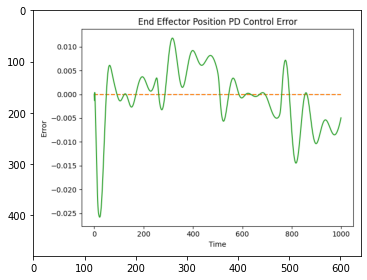

Kp: [[0.579 0.   ]
 [0.    0.579]]
Kd: [[0.0295 0.    ]
 [0.     0.0295]]


In [7]:
get_plot(os.path.join(cwd,"plots/EndEffector_Error.png"))

p = 0.579
d = 0.0295
Kp = np.diag([p, p])
Kd = np.diag([d, d])
print(f"Kp: {Kp}\nKd: {Kd}")

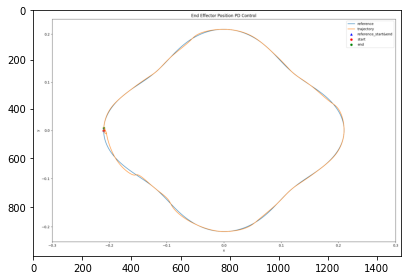

MSE: 2.604663139439981e-05


In [8]:
get_plot(os.path.join(cwd, "plots/EndEffector_traj.png"))
print("MSE: 2.604663139439981e-05")

4. Write out an inverse kinematic solution to the robot that uses the methods from (1)and (2).  Also, derive the analytical inverse kinematic solution; explain what challengesthere would be to use the analytical IK solution to track trajectories.

Analytical solution derivation see appendix.

In [9]:
def getInverseKinematics(self, x: float, y: float) -> Tuple[float, float]:
    """
    Returns the inverse kinematics of the robot.
    :param x: x position of the end-effector
    :param y: y position of the end-effector
    :return: joint angles q0 and q1 in radians
    """
    q1 = np.arccos(
        (x ** 2 + y ** 2 - self.l0 ** 2 - self.l1 ** 2) / (2 * self.l0 * self.l1)
    )
    q0 = np.arctan2(y, x) - np.arctan2(
        self.l1 * np.sin(q1), self.l0 + self.l1 * np.cos(q1)
    )
    return q0, q1

5. Implement a closed loop PD-controller that controls the robot along the given trajectory using the error in the joint-angles as the input signal (keep q_dot_ref= 0). Plot the trajectory of the robot juxtaposed over the actual trajectory and calculatethe mean square error between both paths.  Mention the gains used.

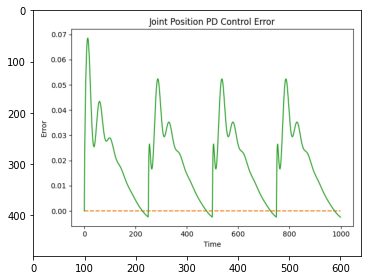

Kp: [[2. 0.]
 [0. 2.]]
Kd: [[0.1 0. ]
 [0.  0.1]]


In [10]:
get_plot(os.path.join(cwd, "plots/Joint_Error.png"))

p = 2.0
d = 0.1
Kp = np.diag([p, p])
Kd = np.diag([d, d])
print(f"Kp: {Kp}\nKd: {Kd}")

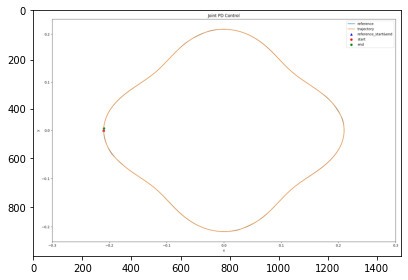

MSE: 8.279904722949787e-06


In [11]:
get_plot(os.path.join(cwd, "plots/Joint_traj.png"))
print("MSE: 8.279904722949787e-06")

# Q2
1. Describe the controller used for following the trajectories.  You may use different gains for different tracks.

I use PD contorller for all tracks.
FigureEight: Kp = 0.1, Kd = 0.35
Circle: Kp = 0.1, Kd = 0.285
Linear: Kp = 0.1, Kd = 0.25

2. Plot the paths of the robot juxtaposed over the desired trajectory.

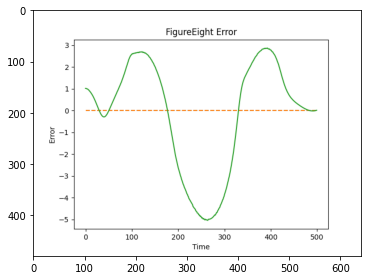

In [12]:
Kp = 0.1
Kd = 0.35
get_plot(os.path.join(cwd, "plots/Figure8_error.png"))


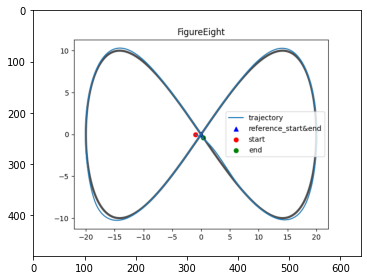

MSE: 3.7017941000790144


In [13]:
get_plot(os.path.join(cwd, "plots/Figure8_traj.png"))
print("MSE: 3.7017941000790144")

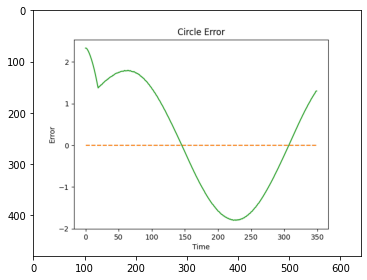

In [14]:
Kp = 0.1
Kd = 0.285
get_plot(os.path.join(cwd, "plots/Circle_error.png"))

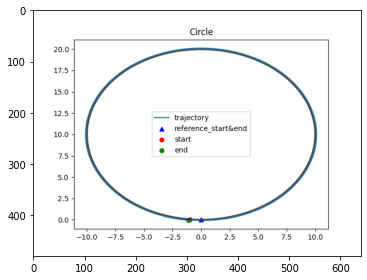

MSE: 0.8617516492924823


In [15]:
get_plot(os.path.join(cwd, "plots/Circle_traj.png"))
print("MSE: 0.8617516492924823")

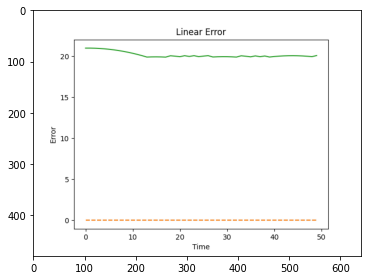

In [16]:
Kp = 1
Kd = 0.1
get_plot(os.path.join(cwd, "plots/Linear_error.png"))

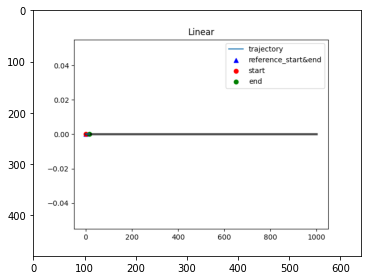

MSE: 203.69821525710296


In [17]:
get_plot(os.path.join(cwd, "plots/Linear_traj.png"))
print("MSE: 203.69821525710296")

Since the max episode length is 50 for track linear. I try to increae the episode length to 200. And it almost finish the track. 

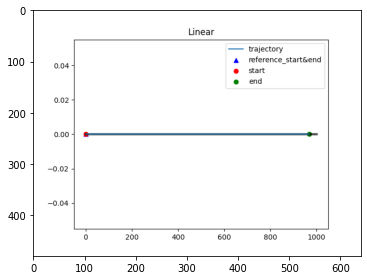

MSE: 203.69821525710296


In [18]:
get_plot(os.path.join(cwd, "plots/Linear_traj_more_step.png"))
print("MSE: 203.69821525710296")